<a href="https://colab.research.google.com/github/Geringer13/Netology_pyda/blob/master/ML_Time_Series2_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [0]:
data = pd.read_csv('international-airline-passengers.csv')['Count']

In [0]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [0]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Не стационарный вариант

In [0]:
data_ns = data

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


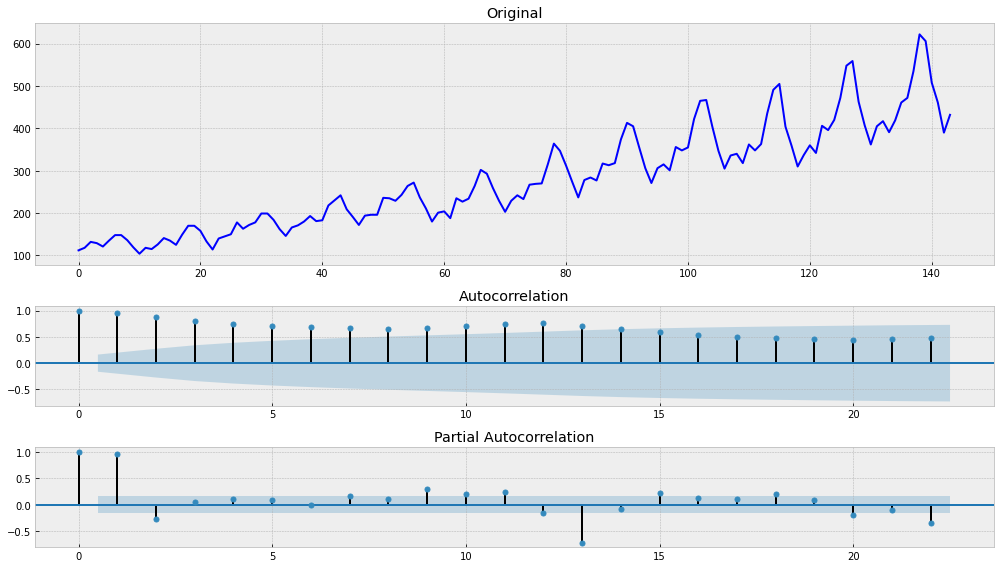

In [7]:
tsplot(data_ns)

Сделаем стационарный вариант, для дальнейшего сравнения

In [0]:
data = boxcox(data, 0)

In [0]:
data = data[1:] - data[:-1]

In [0]:
data = data[12:] - data[:-12]

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


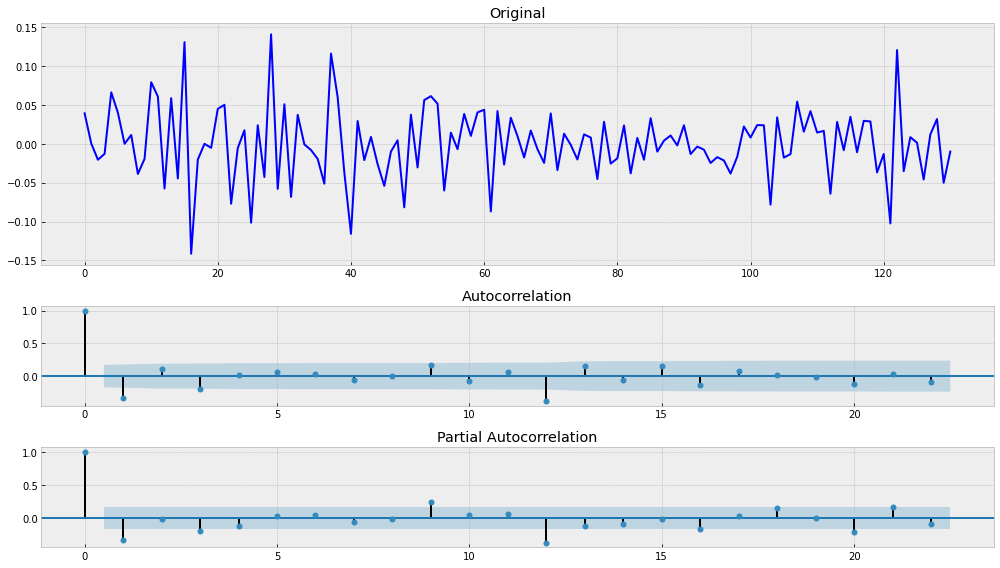

In [11]:
tsplot(data)

Проведём сравнение через МА

In [0]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [0]:
ser_ns = moving_average(data_ns, 7)

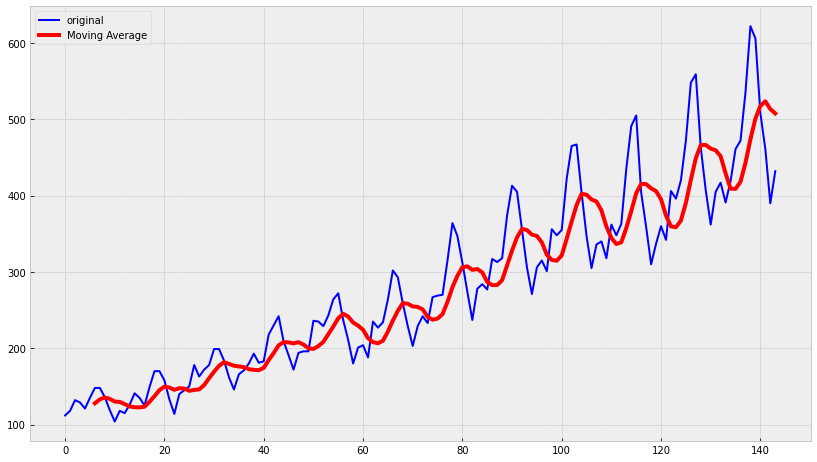

In [14]:
ser_ns = moving_average(data_ns, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(data_ns, color='blue',label='original')
    plt.plot(ser_ns, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [0]:
ser_s = moving_average(data, 7)

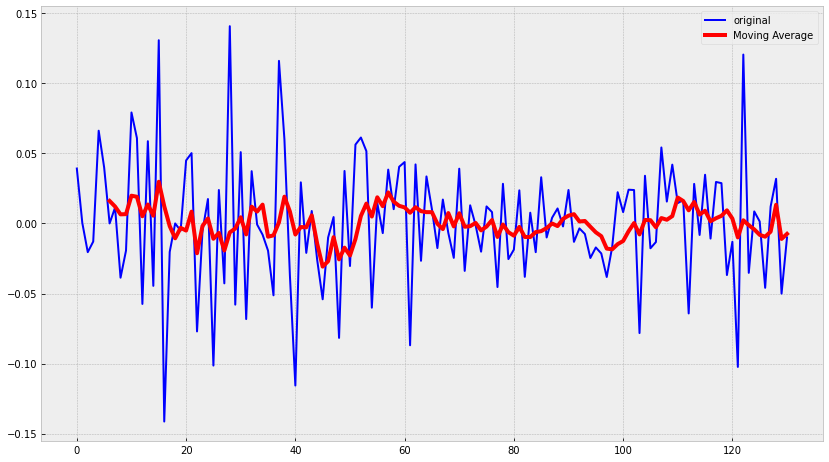

In [16]:
ser_s = moving_average(data, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(data, color='blue',label='original')
    plt.plot(ser_s, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Предскажем 5 следующих значений

In [0]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

Не стационарный

In [0]:
series_pred_ns = predict(data_ns, 7, 50)

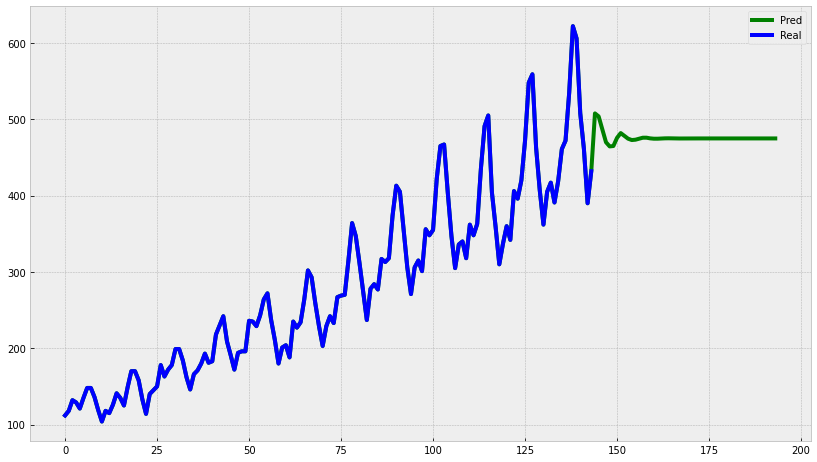

In [19]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred_ns, color='green', linewidth='4', label='Pred')
    plt.plot(data_ns, color='blue', linewidth='4', label='Real')
    plt.legend()

**Добавление: Различные вариации скользящего среднего**

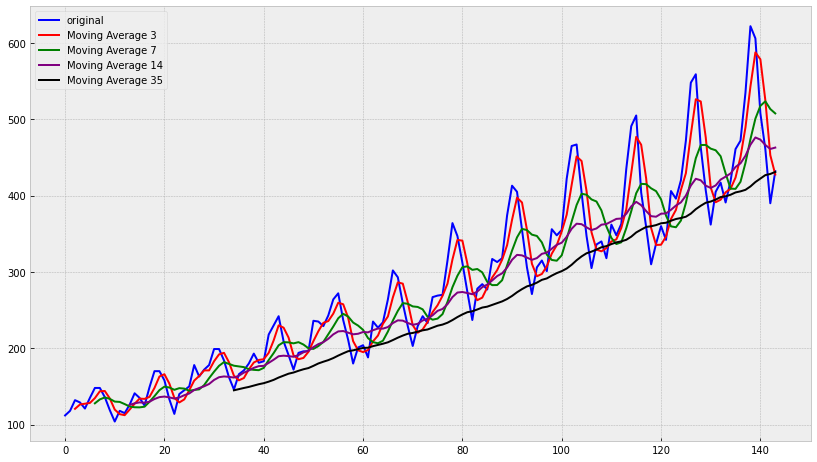

In [23]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(data_ns, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(data_ns, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

Стационарный

In [0]:
data = pd.DataFrame(data)

In [0]:
series_pred_s = predict(data, 7, 50)

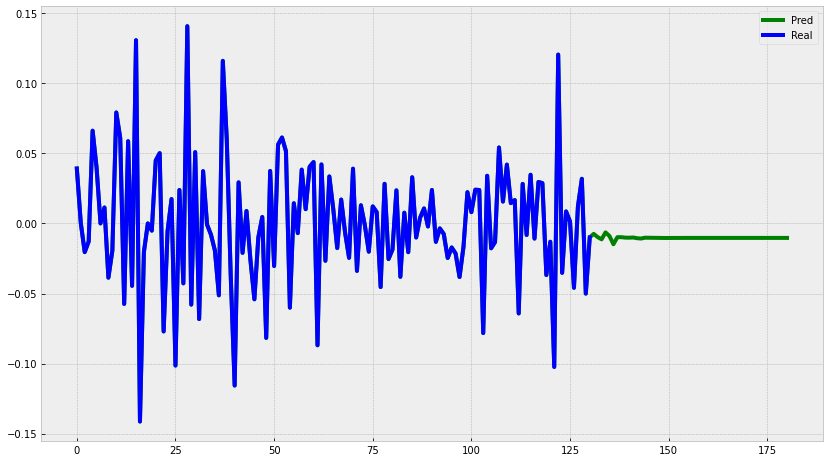

In [22]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred_s, color='green', linewidth='4', label='Pred')
    plt.plot(data, color='blue', linewidth='4', label='Real')
    plt.legend()

**Добавление: двойное экспоненциальное сглаживание**

In [0]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [0]:
def plot_dema(alpha, beta):
    dema = double_ema(data_ns, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(data_ns, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

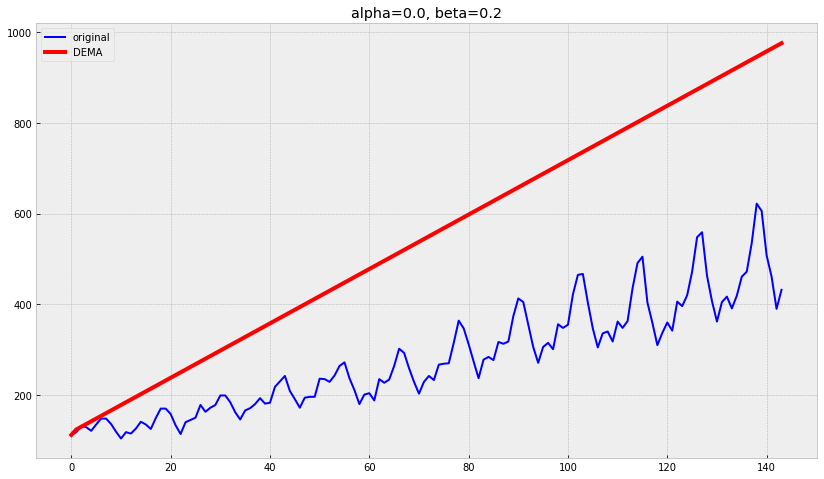

In [35]:
plot_dema(0.0, 0.2)

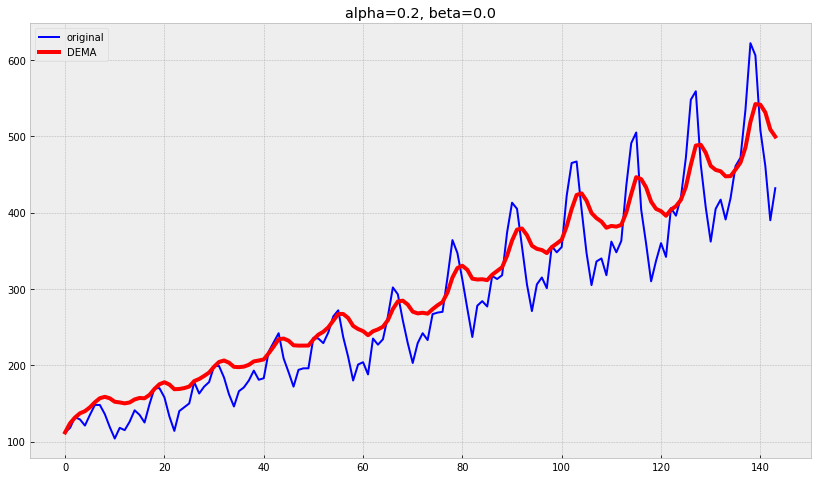

In [34]:
plot_dema(0.2, 0.0)

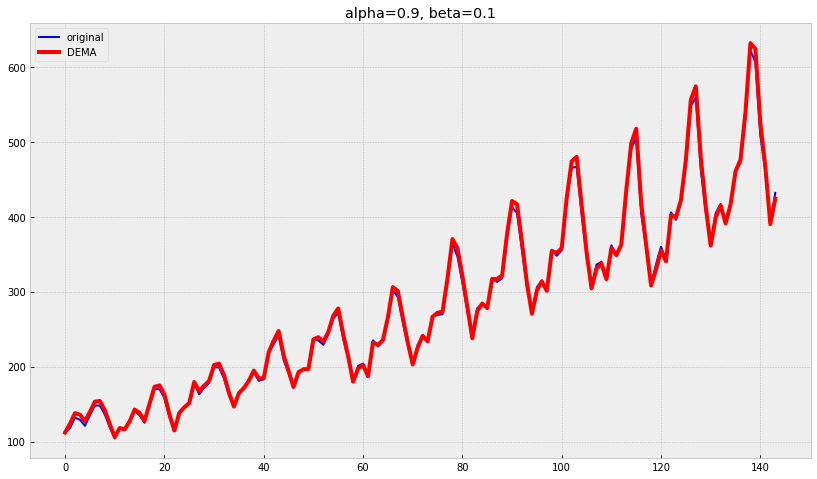

In [40]:
plot_dema(0.9, 0.1)

Предсказывание с помощью двойного экспоненциального сглаживания

In [0]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

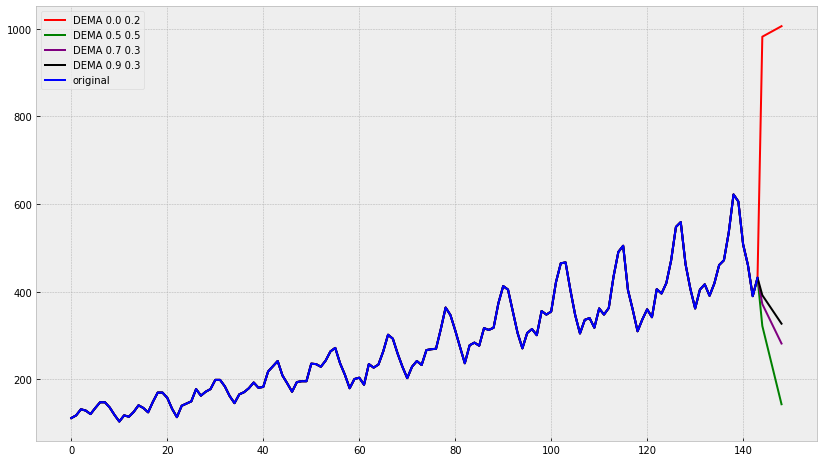

In [46]:
alphas = [0.0,0.5,0.7,0.9]
bettas = [0.2,0.5,0.3,0.3]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(data_ns, alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(data_ns, color='blue',label='original')
    plt.legend()

**Добавление: метод Хольта-Винтерса**

In [0]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [0]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [0]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [0]:
def plot_tema(alpha, beta, gamma, ser=data_ns, ser_to_plot=data_ns, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

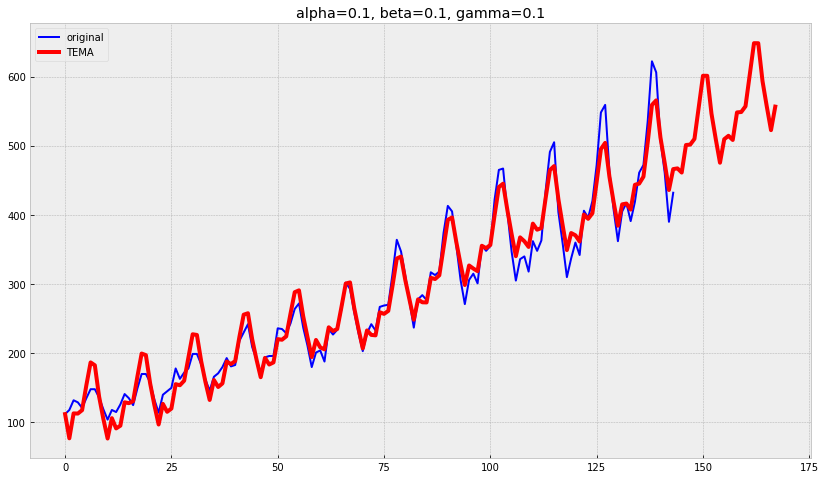

In [52]:
plot_tema(0.1, 0.1, 0.1)

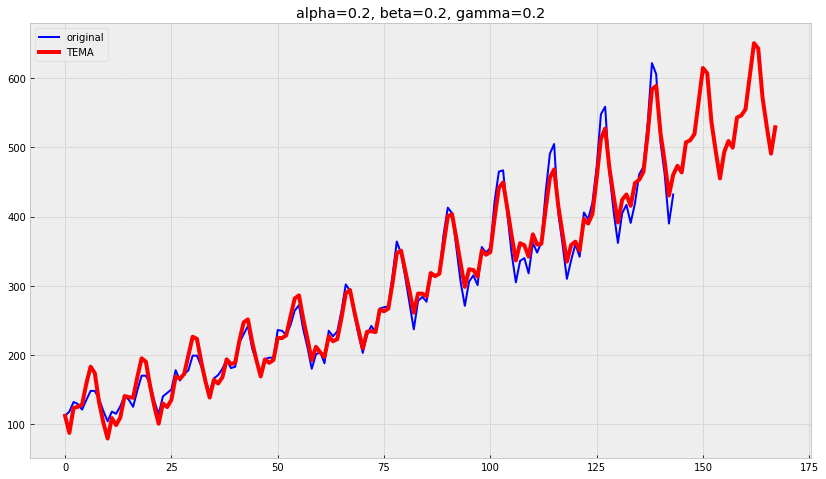

In [55]:
plot_tema(0.2, 0.2, 0.2)

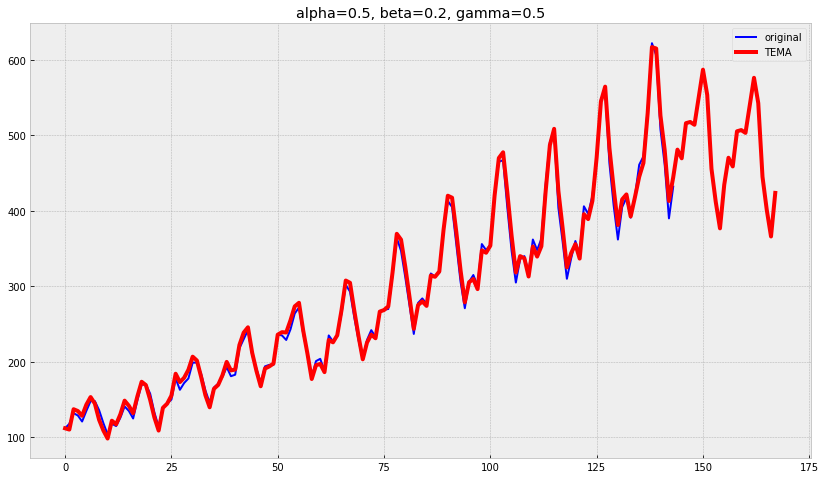

In [72]:
plot_tema(0.5, 0.2, 0.5)

Подбор параметров

In [0]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [0]:
series = data_ns

In [0]:
train, test, val = series[:60], series[60:70], series[70:]

In [0]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [0]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [78]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 175.55254465521995
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-126.59540971,   -0.398623  ,   10.22893912])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 932
      nit: 148
   status: 0
  success: True
        x: array([0.00267391, 0.87720959, 0.        ])


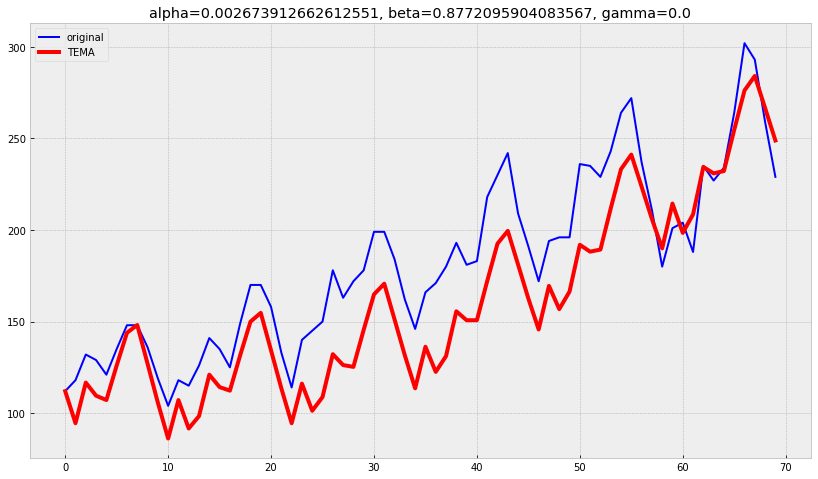

In [79]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

Кросс-валидация

In [0]:
train, val = series[:65], series[65:]

In [0]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [0]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [83]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 174.68168645564376
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.34296146e-02, -1.74304517e+01,  1.47792889e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 208
      nit: 36
   status: 0
  success: True
        x: array([0.02392993, 1.        , 0.03855987])


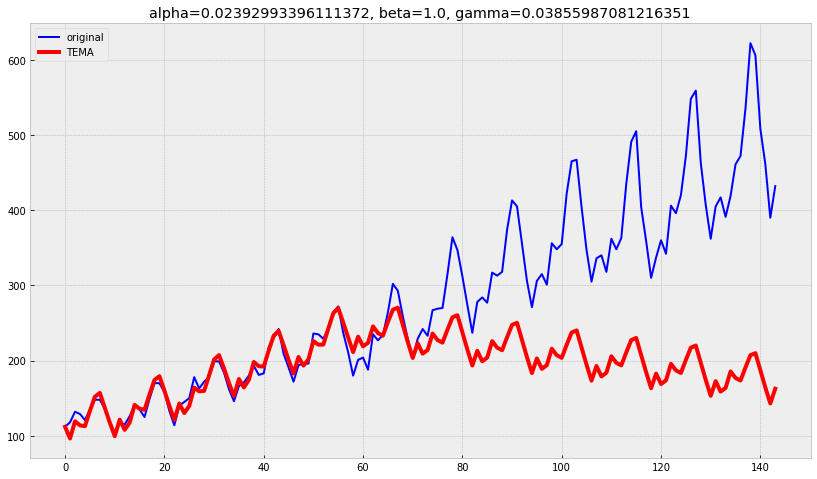

In [84]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))